In [1]:
import numpy as np
import ot
import torch
import matplotlib.pyplot as plt
from causal_cocycle.kernels_new import GaussianKernel, median_heuristic, median_heuristic_ard

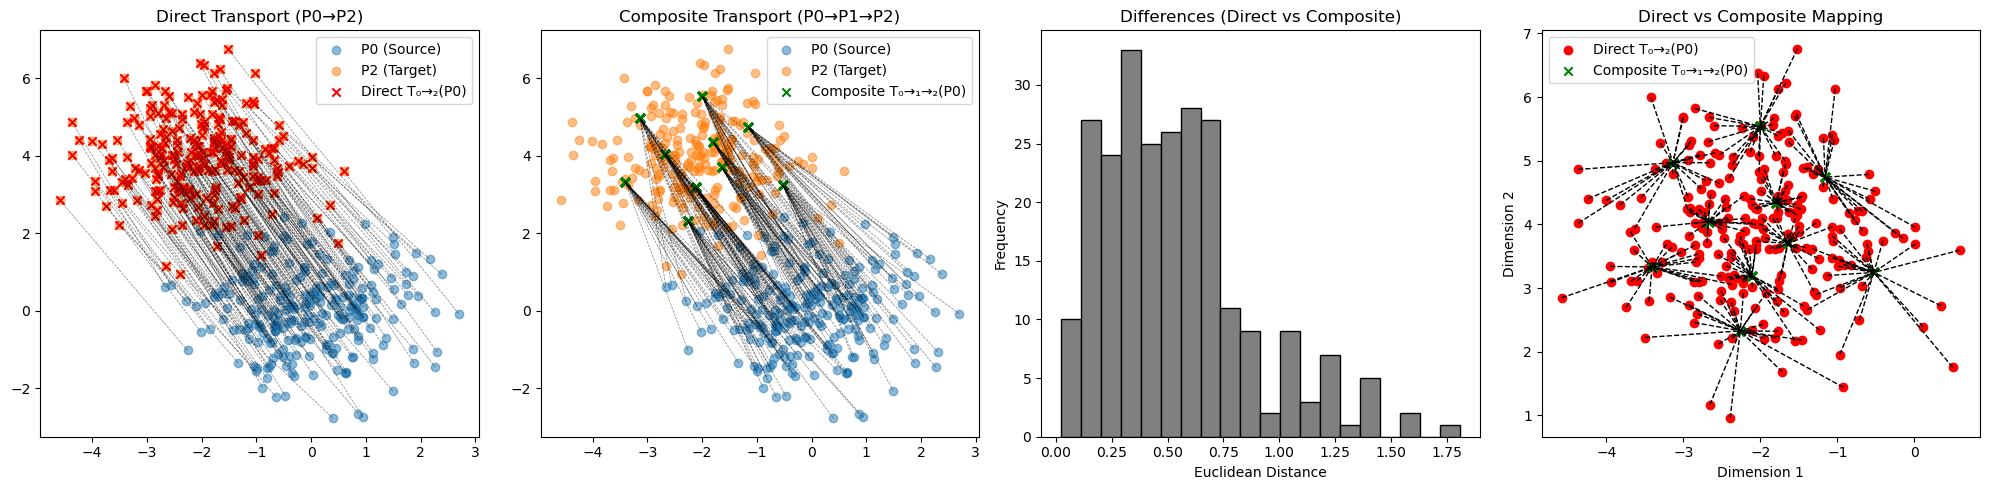

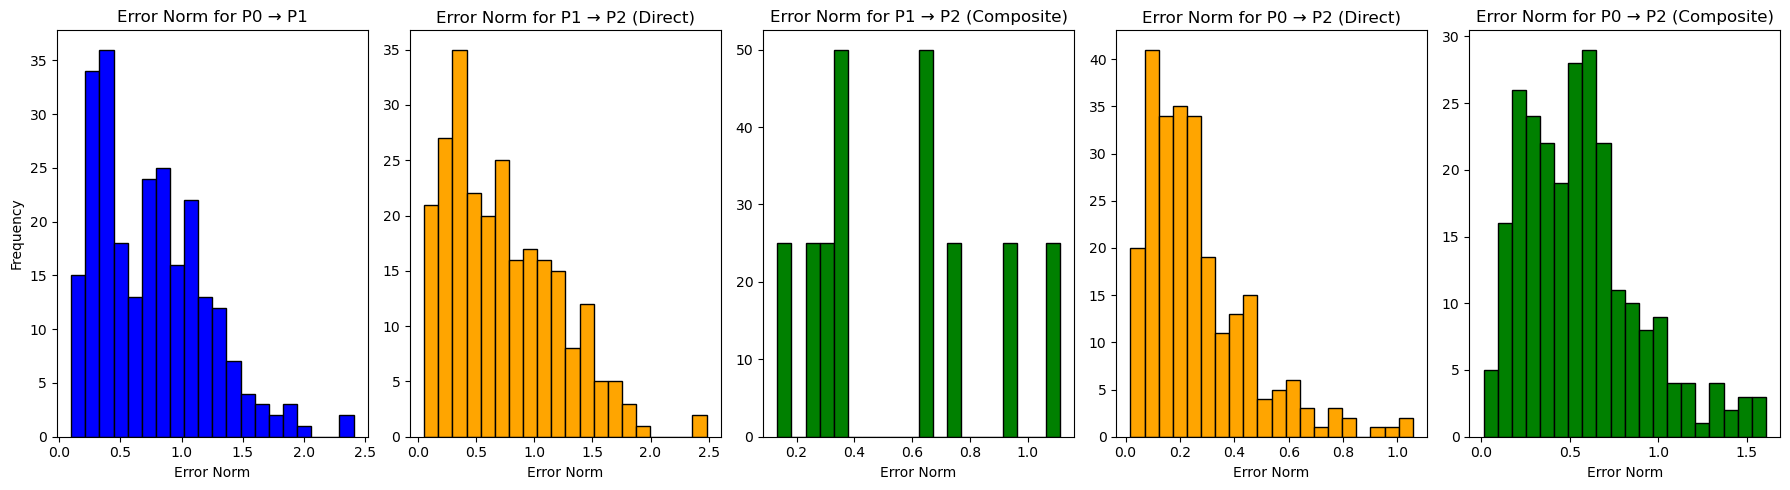

Average error norm for P0 → P1: 0.7539408788695597
Average error norm for P1 → P2 (Direct): 0.7408684655278568
Average error norm for P1 → P2 (Composite): 0.5488868520787418
Average error norm for P0 → P2 (Direct): 0.2646612215157455
Average error norm for P0 → P2 (Composite): 0.5624471898075565
Counterfactual inconsistency (RMSE): 0.4484441996166546


In [2]:
# Set seed for reproducibility
np.random.seed(0)

# Define numbers of samples and dimension
n=250
n0 = n  # number of points in P0
n1 = 10  # number of points in P1
n2 = n  # number of points in P2
dim = 2

dist = "sqeuclidean"

# Generate synthetic data for three distributions
P0 = np.random.randn(n0, dim)                  # P0: standard normal
P1 = np.random.randn(n1, dim) + np.array([3, 3])# P1: shifted by (3,3)
P2 = np.random.randn(n2, dim)+ np.array([-2, 4])# P2: shifted by (-2,4)

# Uniform weights for the empirical measures (each sums to 1)
a0 = np.ones(n0) / n0
a1 = np.ones(n1) / n1
a2 = np.ones(n2) / n2

# Compute cost matrices using Euclidean distance
C01 = ot.dist(P0, P1, dist)  # cost from P0 to P1
C02 = ot.dist(P0, P2, dist)  # cost from P0 to P2 (direct)
C12 = ot.dist(P1, P2, dist)  # cost from P1 to P2

# Compute the optimal transport plans using ot.emd (exact solver)
T01 = ot.emd(a0, a1, C01) / a0[:, None]  # transport plan from P0 to P1; shape: (n0, n1)
T02 = ot.emd(a0, a2, C02) / a0[:, None]   # direct transport plan from P0 to P2; shape: (n0, n2)
T12 = ot.emd(a1, a2, C12) / a1[:, None]  # transport plan from P1 to P2; shape: (n1, n2)

# Compute barycentric projections (maps) to extract deterministic mappings:
# For each sample in the source, compute the weighted average of the target points.
Tmap_01 = np.dot(T01, P1)   # mapping from P0 to P1; shape: (n0, dim)
Tmap_02 = np.dot(T02, P2)  # direct mapping from P0 to P2; shape: (n0, dim)
Tmap_12 = np.dot(T12, P2)  # mapping from P1 to P2; shape: (n1, dim)

# Compose the mapping from P0 -> P1 -> P2:
# Assert that T01 doesn't split mass (approximately):
assert((T01**2).sum(0).all() == 1)

#assert(((T01.sum(1)/a0) == 1).all())# and  ((T01.sum(1)/a0) == 1).all())
# Here we extract the permutation by taking the argmax along each row.
perm = np.argmax(T01, axis=1)  # This gives the index in P1 for each point in P0
# Now, Tmap_01 should be exactly P1[perm] (if T01 were an exact permutation)
Tmap_01_permuted = P1[perm]
# Now, we define a "permuted" T21 mapping, where we reorder Tmap_12 according to perm:
Tmap_12_permuted = Tmap_12[perm]
# Finally, the composite mapping from P0 to P2 via P1 is simply:
Tmap_012 = Tmap_12_permuted
# Compute distances between direct and composite mapping points (for reference)
diff = Tmap_02 - Tmap_012
distances = np.linalg.norm(diff, axis=1)

# Create a single figure with 4 subplots arranged in one row
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Direct Transport (P0 -> P2) with connecting lines from source to transport
axes[0].scatter(P0[:, 0], P0[:, 1], label='P0 (Source)', alpha=0.5)
axes[0].scatter(P2[:, 0], P2[:, 1], label='P2 (Target)', alpha=0.5)
axes[0].scatter(Tmap_02[:, 0], Tmap_02[:, 1], marker='x', color='red', label='Direct T₀→₂(P0)')
for i in range(n0):
    axes[0].plot([P0[i, 0], Tmap_02[i, 0]], [P0[i, 1], Tmap_02[i, 1]], 'k--', linewidth=0.5, alpha = 0.5)
axes[0].set_title('Direct Transport (P0→P2)')
axes[0].legend()

# Plot 2: Composite Transport (P0 -> P1 -> P2) with connecting lines from source to transport
axes[1].scatter(P0[:, 0], P0[:, 1], label='P0 (Source)', alpha=0.5)
axes[1].scatter(P2[:, 0], P2[:, 1], label='P2 (Target)', alpha=0.5)
axes[1].scatter(Tmap_012[:, 0], Tmap_012[:, 1], marker='x', color='green', label='Composite T₀→₁→₂(P0)')
for i in range(n0):
    axes[1].plot([P0[i, 0], Tmap_012[i, 0]], [P0[i, 1], Tmap_012[i, 1]], 'k--', linewidth=0.5, alpha = 0.5)
axes[1].set_title('Composite Transport (P0→P1→P2)')
axes[1].legend()

# Plot 3: Histogram of distances between Direct and Composite mappings
axes[2].hist(distances, bins=20, color='gray', edgecolor='black')
axes[2].set_title('Differences (Direct vs Composite)')
axes[2].set_xlabel('Euclidean Distance')
axes[2].set_ylabel('Frequency')

# Plot 4: Overlay of Direct vs Composite mappings with connecting lines
axes[3].scatter(Tmap_02[:, 0], Tmap_02[:, 1], color='red', label='Direct T₀→₂(P0)', marker='o')
axes[3].scatter(Tmap_012[:, 0], Tmap_012[:, 1], color='green', label='Composite T₀→₁→₂(P0)', marker='x')
for i in range(n0):
    axes[3].plot([Tmap_02[i, 0], Tmap_012[i, 0]],
                 [Tmap_02[i, 1], Tmap_012[i, 1]], 'k--', linewidth=1.0)
axes[3].set_title('Direct vs Composite Mapping')
axes[3].set_xlabel('Dimension 1')
axes[3].set_ylabel('Dimension 2')
axes[3].legend()

plt.tight_layout()
plt.show()

# --------------------------
# Now, compute the estimated differences and compare to the true counterfactual shifts.
# In our example:
#   True difference for P0 -> P1: (3, 3)
#   True difference for P1 -> P2: (P2 shift - P1 shift) = (-2, 4) - (3, 3) = (-5, 1)

true_diff_01 = np.array([3, 3])
true_diff_21 = np.array([-5, 1])
true_diff_20 = true_diff_21 + true_diff_01

# Estimated difference from P0 to P1 (using the P0 -> P1 transport)
diff_est_01 = Tmap_01 - P0  # estimated change from P0 to P1

# Estimated difference from P1 to P2 can be estimated in two ways:
# a) Directly from the direct mapping: (Tmap_02 - Tmap_01)
# b) Using the composite mapping: (Tmap_012 - Tmap_01)
diff_est_21_direct = Tmap_02 - Tmap_01
diff_est_21_composite = Tmap_012 - Tmap_01

# Estimated difference from P0 to P2 can be estimated in two ways:
# a) Directly from the direct mapping: (Tmap_02 - P0)
# b) Using the composite mapping: (Tmap_012 - P0)
diff_est_20_direct = Tmap_02 - P0
diff_est_20_composite = Tmap_012 - P0


# Compute errors relative to the true differences
error_01 = diff_est_01 - true_diff_01      # error for P0 -> P1
error_21_direct = diff_est_21_direct - true_diff_21  # error for P1 -> P2 using direct mapping
error_21_composite = diff_est_21_composite - true_diff_21  # error for P1 -> P2 using composite mapping
error_20_direct = diff_est_20_direct - true_diff_20  # error for P0 -> P2 using direct mapping
error_20_composite = diff_est_20_composite - true_diff_20  # error for P0 -> P2 using composite mapping

# Compute Euclidean norms of these errors for a quantitative measure
norm_error_01 = np.linalg.norm(error_01, axis=1)
norm_error_21_direct = np.linalg.norm(error_21_direct, axis=1)
norm_error_21_composite = np.linalg.norm(error_21_composite, axis=1)
norm_error_20_direct = np.linalg.norm(error_20_direct, axis=1)
norm_error_20_composite = np.linalg.norm(error_20_composite, axis=1)

# Plot histograms of these error norms in a new figure with 3 subplots
fig2, axes2 = plt.subplots(1, 5, figsize=(18, 5))

axes2[0].hist(norm_error_01, bins=20, color='blue', edgecolor='black')
axes2[0].set_title('Error Norm for P0 → P1')
axes2[0].set_xlabel('Error Norm')
axes2[0].set_ylabel('Frequency')

axes2[1].hist(norm_error_21_direct, bins=20, color='orange', edgecolor='black')
axes2[1].set_title('Error Norm for P1 → P2 (Direct)')
axes2[1].set_xlabel('Error Norm')

axes2[2].hist(norm_error_21_composite, bins=20, color='green', edgecolor='black')
axes2[2].set_title('Error Norm for P1 → P2 (Composite)')
axes2[2].set_xlabel('Error Norm')

axes2[3].hist(norm_error_20_direct, bins=20, color='orange', edgecolor='black')
axes2[3].set_title('Error Norm for P0 → P2 (Direct)')
axes2[3].set_xlabel('Error Norm')

axes2[4].hist(norm_error_20_composite, bins=20, color='green', edgecolor='black')
axes2[4].set_title('Error Norm for P0 → P2 (Composite)')
axes2[4].set_xlabel('Error Norm')

plt.tight_layout()
plt.show()

# Optionally, print the average error norms
print("Average error norm for P0 → P1:", np.mean(norm_error_01))
print("Average error norm for P1 → P2 (Direct):", np.mean(norm_error_21_direct))
print("Average error norm for P1 → P2 (Composite):", np.mean(norm_error_21_composite))
print("Average error norm for P0 → P2 (Direct):", np.mean(norm_error_20_direct))
print("Average error norm for P0 → P2 (Composite):", np.mean(norm_error_20_composite))
print("Counterfactual inconsistency (RMSE):", ((Tmap_02 - Tmap_012)**2).mean()**0.5)

## KR cocycle estimation

In [3]:
ls_best = median_heuristic(torch.tensor(P0)[:,:1])
print(ls_best)

tensor(0.6962, dtype=torch.float64)


/tmp/ipykernel_2991293/1272904886.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel = GaussianKernel(lengthscale=torch.tensor(ls_best))


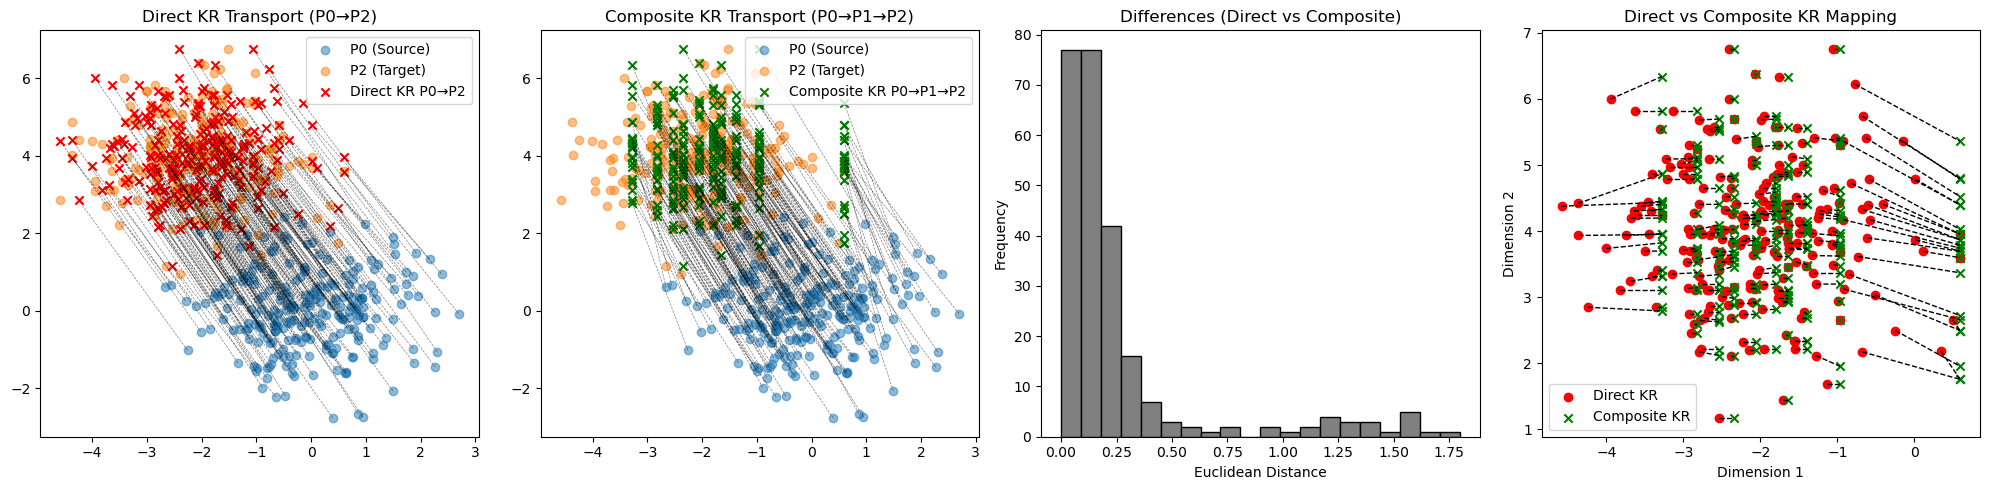

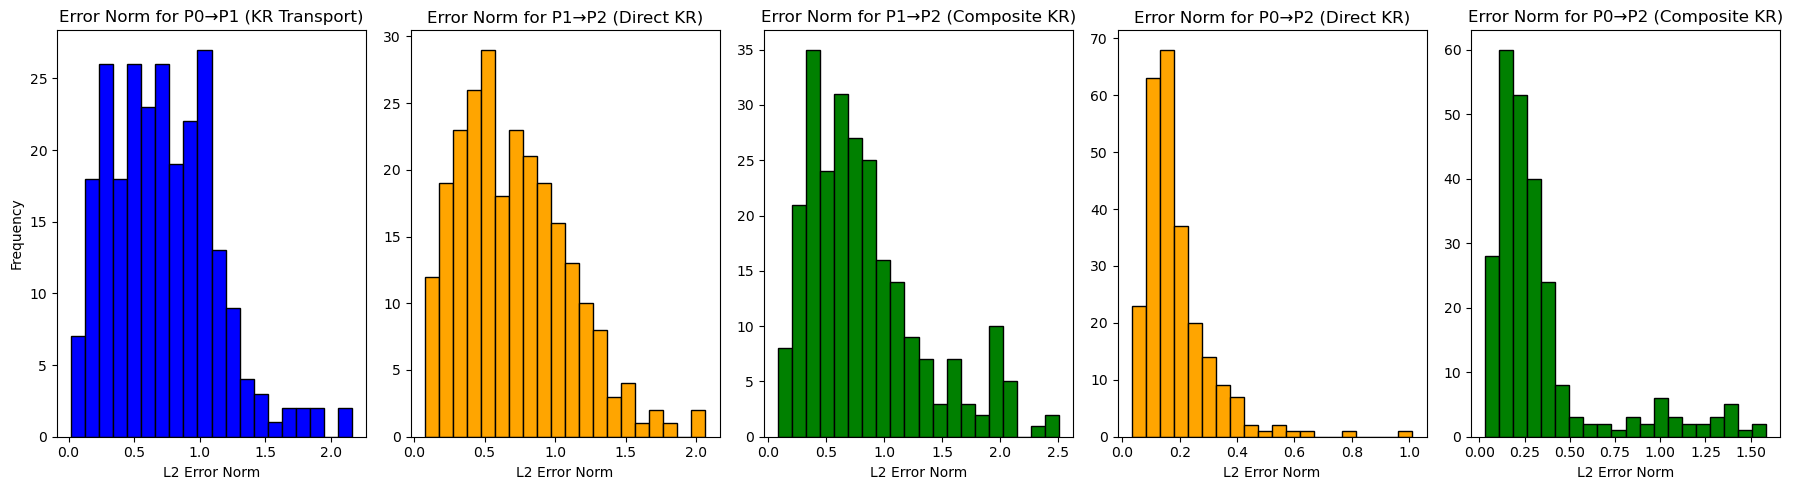

Average error norm for P0→P1 (KR Transport): 0.7226140502562217
Average error norm for P1→P2 (Direct KR): 0.7045167749694454
Average error norm for P1→P2 (Composite KR): 0.8374046081628396
Average error norm for P0→P2 (Direct KR): 0.18589159250468085
Average error norm for P0→P2 (Composite KR): 0.3454869287741743
Counterfactual inconsistency (RMSE): tensor(0.3221, dtype=torch.float64)


In [4]:
# ----------------------------
# Helper functions (assumed defined)
# ----------------------------

def compute_weights_from_kernel(kernel, X1, x1_query):
    """
    Returns normalized weights w_i(x1_query) using kernel.get_gram().
    X1 is a 1D tensor of training values.
    x1_query is a scalar (or 0D tensor).
    """
    if x1_query.dim() == 0:
        x1_query = x1_query.view(1, 1)
    elif x1_query.dim() == 1:
        x1_query = x1_query.unsqueeze(0)
    if X1.dim() == 1:
        X1 = X1.unsqueeze(1)
    K_vals = kernel.get_gram(x1_query, X1).flatten()
    return K_vals / K_vals.sum()

# Modified KR transport (1D) with provided weights
def build_KR_map(X: torch.Tensor, Y: torch.Tensor, 
                                                   w_src: torch.Tensor = None, w_tgt: torch.Tensor = None, epsilon: float = 1e-8):

    # Get weights if not provided
    if w_src is None:
        n_src = X.numel()
        w_src = torch.ones(n_src, device=X.device) / n_src
    if w_tgt is None:
        n_tgt = Y.numel()
        w_tgt = torch.ones(n_tgt, device=Y.device) / n_tgt
    
    # Sort X and Y first
    X_sorted_full, idx_X = torch.sort(X)
    Y_sorted_full, idx_Y = torch.sort(Y)
    w_src_sorted_full = w_src[idx_X]
    w_tgt_sorted_full = w_tgt[idx_Y]
    
    # Get unique sorted values for X, and sum the weights of duplicates.
    X_sorted, inverse_idx_X = torch.unique(X_sorted_full, sorted=True, return_inverse=True)
    w_src_sorted = torch.zeros_like(X_sorted, dtype=w_src.dtype)
    w_src_sorted = w_src_sorted.scatter_add_(0, inverse_idx_X, w_src_sorted_full)
    
    # Do the same for Y.
    Y_sorted, inverse_idx_Y = torch.unique(Y_sorted_full, sorted=True, return_inverse=True)
    w_tgt_sorted = torch.zeros_like(Y_sorted, dtype=w_tgt.dtype)
    w_tgt_sorted = w_tgt_sorted.scatter_add_(0, inverse_idx_Y, w_tgt_sorted_full)
    
    # Normalize the weights.
    w_src_sorted = w_src_sorted / w_src_sorted.sum()
    w_tgt_sorted = w_tgt_sorted / w_tgt_sorted.sum()

    
    def S(z):
        z = z.double()
        if epsilon == 0:
            return (z>=0).float()
        else:
            return torch.where(z < -epsilon, torch.zeros_like(z),
                               torch.where(z > epsilon, torch.ones_like(z),
                                           (z + epsilon) / (2 * epsilon)))
    def F_src(y):
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, device=X_sorted.device)
        if y.dim() == 0:
            y = y.unsqueeze(0)
        if y.dim() == 1:
            y = y.unsqueeze(1)
        X_exp = X_sorted.unsqueeze(0)
        S_vals = S(y - X_exp)
        return torch.sum(w_src_sorted * S_vals, dim=-1)
    def Q_tgt(t):
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=Y_sorted.device)
        if t.dim() > 1:
            t = t.squeeze(-1)
        cumsum = torch.cumsum(w_tgt_sorted, dim=0)
        indices = torch.searchsorted(cumsum, t.unsqueeze(1)).squeeze(1)
        indices = torch.clamp(indices, 0, Y_sorted.numel()-1)
        j = indices-1
        j_next = indices
        cumsum = torch.concatenate((torch.zeros(1),cumsum))
        cumsum_j = cumsum[j+1]
        w_j_next = w_tgt_sorted[j_next]
        s = (t - cumsum_j) / w_j_next
        Y_j_next = Y_sorted[j_next].double()
        Y_prev = Y_sorted[torch.clamp(j, min=0)].double()
        return Y_j_next - epsilon + 2 * epsilon * s        
    def KR(y):
        t_val = F_src(y)
        return Q_tgt(t_val)
    return KR

# ----------------------------
# End-to-end KR transport procedure
# ----------------------------

# Convert to torch tensors
Y0 = torch.tensor(P0, dtype=torch.float64)
Y1 = torch.tensor(P1, dtype=torch.float64)
Y2 = torch.tensor(P2, dtype=torch.float64)

# ----------------------------
# KR transport for the first dimension (1D maps
epsilon = 0

# Use uniform weights here (empirical CDF)
KR10 = build_KR_map(Y0[:,0], Y1[:,0], epsilon=epsilon)
KR21 = build_KR_map(Y1[:,0], Y2[:,0], epsilon=epsilon)
KR20 = build_KR_map(Y0[:,0], Y2[:,0], epsilon=epsilon)

Yhat1 = KR10(Y0[:,0])           # Transport P0 -> P1, first coordinate
Yhat2_direct = KR20(Y0[:,0])      # Direct transport P0 -> P2, first coordinate
Yhat2_composite = KR21(Yhat1)     # Composite transport P0 -> P1 -> P2, first coordinate

# ----------------------------
# For the second dimension we use the weighted KR transport.
# We'll set a small epsilon (e.g., 1e-8) for the smoothing function.
kernel = GaussianKernel(lengthscale=torch.tensor(ls_best))

mapped_second_direct = []
mapped_second_composite = []
mapped_second_1 = []

# For each sample in P0, compute the conditional KR transport for the second dimension.
for i in range(Y0.shape[0]):
    # Extract source coordinates from P0:
    x1_0 = Y0[i, 0]
    x2_0 = Y0[i, 1]
    X2 = Y0[:, 1]  # second coordinates of P0
    
    # Compute source conditional weights from the first coordinate using uniform (empirical) weighting
    # For the conditional KR on the second dimension for P0 -> P1:
    w_src = compute_weights_from_kernel(kernel, Y0[:,0], x1_0)
    
    # ----- For P0 -> P1 (for the second coordinate) -----
    # Compute target conditional weights using the first-coordinate mapping from P0->P1
    w_tgt_1 = compute_weights_from_kernel(kernel, Y1[:,0], KR10(x1_0))
    Y1_2 = Y1[:,1]
    KR_2_1 = build_KR_map(X2, Y1_2, w_src, w_tgt_1, epsilon)
    mapped_second_1.append(KR_2_1(x2_0).item())
    
    # ----- For direct P0 -> P2 -----
    w_tgt_direct = compute_weights_from_kernel(kernel, Y2[:,0], KR20(x1_0))
    Y2_direct = Y2[:,1]
    KR_2_direct = build_KR_map(X2, Y2_direct, w_src, w_tgt_direct, epsilon)
    mapped_second_direct.append(KR_2_direct(x2_0).item())
    
    # ----- For composite transport P0 -> P1 -> P2 -----
    # Use the first-dim composite mapping: x1_hat from Yhat1 (which is P0 -> P1)
    x1_hat = Yhat1[i]
    w_tgt_composite = compute_weights_from_kernel(kernel, Y2[:,0], KR21(x1_hat))
    KR_2_composite = build_KR_map(X2, Y2[:,1], w_src, w_tgt_composite, epsilon)
    mapped_second_composite.append(KR_2_composite(x2_0).item())

mapped_second_1 = torch.tensor(mapped_second_1)
mapped_second_direct = torch.tensor(mapped_second_direct)
mapped_second_composite = torch.tensor(mapped_second_composite)

# Construct full 2D transported points:
Yhat1_2d = torch.stack([Yhat1, mapped_second_1], dim=1)
Yhat2_direct_2d = torch.stack([Yhat2_direct, mapped_second_direct], dim=1)
Yhat2_composite_2d = torch.stack([Yhat2_composite, mapped_second_composite], dim=1)

# ----------------------------
# Now, plot the results (similar to the OT plots)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Direct KR Transport (P0 -> P2) with connecting lines from source to transport
axes[0].scatter(Y0[:,0], Y0[:,1], label='P0 (Source)', alpha=0.5)
axes[0].scatter(Y2[:,0], Y2[:,1], label='P2 (Target)', alpha=0.5)
axes[0].scatter(Yhat2_direct_2d[:,0], Yhat2_direct_2d[:,1], marker='x', color='red', label='Direct KR P0→P2')
for i in range(n0):
    axes[0].plot([Y0[i,0], Yhat2_direct_2d[i,0]], [Y0[i,1], Yhat2_direct_2d[i,1]], 'k--', linewidth=0.5, alpha=0.5)
axes[0].set_title('Direct KR Transport (P0→P2)')
axes[0].legend()

# Plot 2: Composite KR Transport (P0 -> P1 -> P2) with connecting lines from source to transport
axes[1].scatter(Y0[:,0], Y0[:,1], label='P0 (Source)', alpha=0.5)
axes[1].scatter(Y2[:,0], Y2[:,1], label='P2 (Target)', alpha=0.5)
axes[1].scatter(Yhat2_composite_2d[:,0], Yhat2_composite_2d[:,1], marker='x', color='green', label='Composite KR P0→P1→P2')
for i in range(n0):
    axes[1].plot([Y0[i,0], Yhat2_composite_2d[i,0]], [Y0[i,1], Yhat2_composite_2d[i,1]], 'k--', linewidth=0.5, alpha=0.5)
axes[1].set_title('Composite KR Transport (P0→P1→P2)')
axes[1].legend()

# Plot 3: Histogram of distances between direct and composite KR transports
distances_KR = torch.norm(Yhat2_direct_2d - Yhat2_composite_2d, dim=1).numpy()
axes[2].hist(distances_KR, bins=20, color='gray', edgecolor='black')
axes[2].set_title('Differences (Direct vs Composite)')
axes[2].set_xlabel('Euclidean Distance')
axes[2].set_ylabel('Frequency')

# Plot 4: Overlay of Direct vs Composite KR transports with connecting lines
axes[3].scatter(Yhat2_direct_2d[:,0], Yhat2_direct_2d[:,1], color='red', label='Direct KR', marker='o')
axes[3].scatter(Yhat2_composite_2d[:,0], Yhat2_composite_2d[:,1], color='green', label='Composite KR', marker='x')
for i in range(n0):
    axes[3].plot([Yhat2_direct_2d[i,0], Yhat2_composite_2d[i,0]], [Yhat2_direct_2d[i,1], Yhat2_composite_2d[i,1]], 'k--', linewidth=1.0)
axes[3].set_title('Direct vs Composite KR Mapping')
axes[3].set_xlabel('Dimension 1')
axes[3].set_ylabel('Dimension 2')
axes[3].legend()

plt.tight_layout()
plt.show()

# ----------------------------
# Compute error statistics relative to the true shifts

# True shifts:
true_shift_01 = np.array([3, 3])      # P0 -> P1
true_shift_21 = np.array([-5, 1])       # P1 -> P2
true_shift_20 = true_shift_21 + true_shift_01      # P1 -> P2

# Compute error for P0 -> P1:
# Estimated shift for P0 -> P1 (full 2D) is Yhat1_2d - Y0.
delta_01 = (Yhat1_2d - Y0).numpy()     # shape: (n, 2)
error_01 = delta_01 - true_shift_01      # error compared to [3, 3]
norm_error_01 = np.linalg.norm(error_01, axis=1)  # L2 norm per sample

# Compute error for P1 -> P2:
# For the direct KR transport, the estimated shift is (Yhat2_direct_2d - Yhat1_2d)
delta_21_direct = (Yhat2_direct_2d - Yhat1_2d).numpy()
error_21_direct = delta_21_direct - true_shift_21
norm_error_21_direct = np.linalg.norm(error_21_direct, axis=1)

# For the composite KR transport, the estimated shift is (Yhat2_composite_2d - Yhat1_2d)
delta_21_composite = (Yhat2_composite_2d - Yhat1_2d).numpy()
error_21_composite = delta_21_composite - true_shift_21
norm_error_21_composite = np.linalg.norm(error_21_composite, axis=1)

# Compute error for P1 -> P2:
# For the direct KR transport, the estimated shift is (Yhat2_direct_2d - Yhat1_2d)
delta_20_direct = (Yhat2_direct_2d - Y0).numpy()
error_20_direct = delta_20_direct - true_shift_20
norm_error_20_direct = np.linalg.norm(error_20_direct, axis=1)

# For the composite KR transport, the estimated shift is (Yhat2_composite_2d - Yhat1_2d)
delta_20_composite = (Yhat2_composite_2d - Y0).numpy()
error_20_composite = delta_20_composite - true_shift_20
norm_error_20_composite = np.linalg.norm(error_20_composite, axis=1)

# ----------------------------
# Plot error norm histograms for all three cases
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Error norm for P0 → P1
axes[0].hist(norm_error_01, bins=20, color='blue', edgecolor='black')
axes[0].set_title('Error Norm for P0→P1 (KR Transport)')
axes[0].set_xlabel('L2 Error Norm')
axes[0].set_ylabel('Frequency')

# Error norm for P1 → P2 (Direct KR)
axes[1].hist(norm_error_21_direct, bins=20, color='orange', edgecolor='black')
axes[1].set_title('Error Norm for P1→P2 (Direct KR)')
axes[1].set_xlabel('L2 Error Norm')

# Error norm for P1 → P2 (Composite KR)
axes[2].hist(norm_error_21_composite, bins=20, color='green', edgecolor='black')
axes[2].set_title('Error Norm for P1→P2 (Composite KR)')
axes[2].set_xlabel('L2 Error Norm')

# Error norm for P0 → P2 (Direct KR)
axes[3].hist(norm_error_20_direct, bins=20, color='orange', edgecolor='black')
axes[3].set_title('Error Norm for P0→P2 (Direct KR)')
axes[3].set_xlabel('L2 Error Norm')

# Error norm for P0 → P2 (Composite KR)
axes[4].hist(norm_error_20_composite, bins=20, color='green', edgecolor='black')
axes[4].set_title('Error Norm for P0→P2 (Composite KR)')
axes[4].set_xlabel('L2 Error Norm')

plt.tight_layout()
plt.show()

# ----------------------------
# Print average error norms
print("Average error norm for P0→P1 (KR Transport):", np.mean(norm_error_01))
print("Average error norm for P1→P2 (Direct KR):", np.mean(norm_error_21_direct))
print("Average error norm for P1→P2 (Composite KR):", np.mean(norm_error_21_composite))
print("Average error norm for P0→P2 (Direct KR):", np.mean(norm_error_20_direct))
print("Average error norm for P0→P2 (Composite KR):", np.mean(norm_error_20_composite))
print("Counterfactual inconsistency (RMSE):", ((Yhat2_direct_2d-Yhat2_composite_2d)**2).mean()**0.5)

/tmp/ipykernel_2991293/2399673368.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel = GaussianKernel(lengthscale=torch.tensor(ls_best))


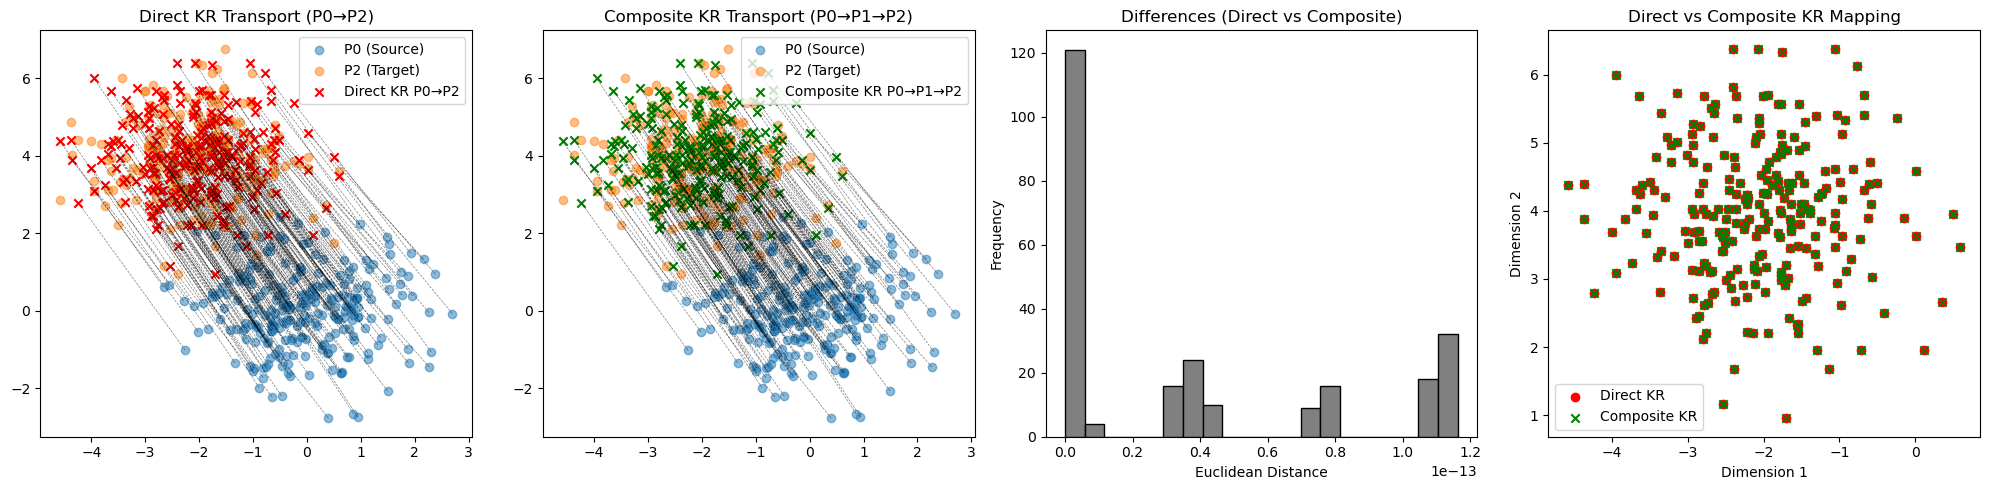

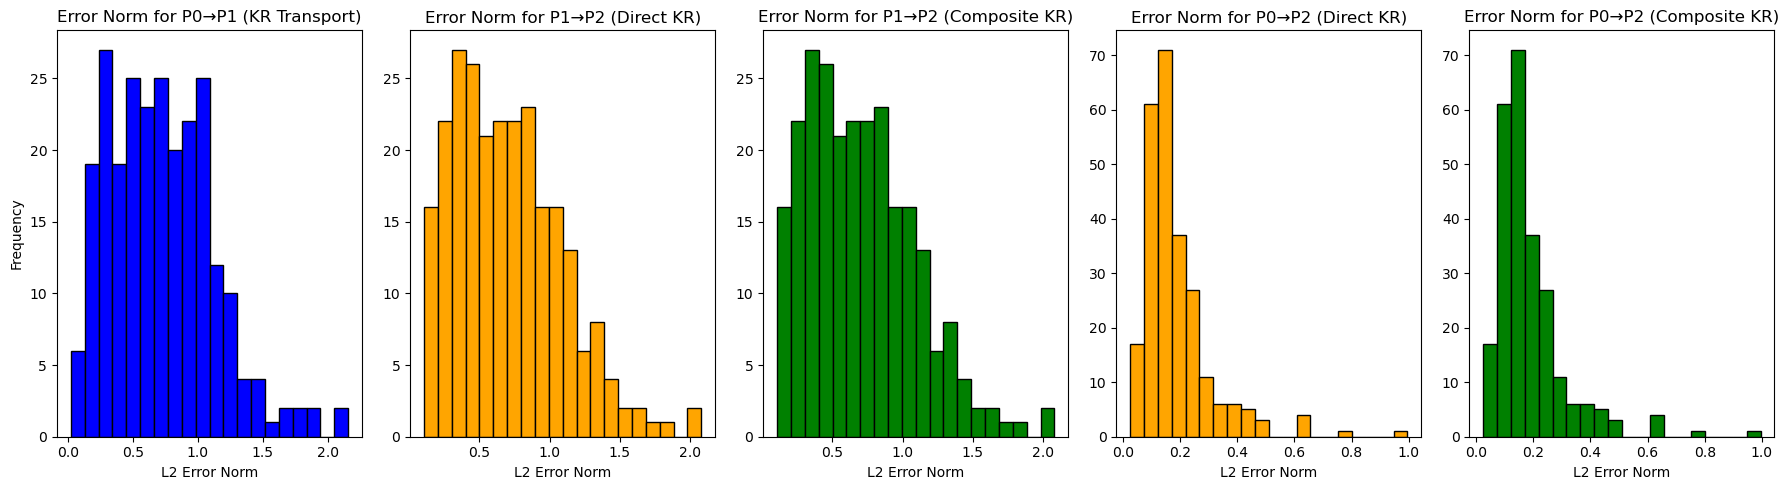

Average error norm for P0→P1 (KR Transport): 0.7219923766572836
Average error norm for P1→P2 (Direct KR): 0.7062203040489503
Average error norm for P1→P2 (Composite KR): 0.7062203040489586
Average error norm for P0→P2 (Direct KR): 0.18589401983962975
Average error norm for P0→P2 (Composite KR): 0.18589401983962933
Counterfactual inconsistency (RMSE): tensor(4.1067e-14, dtype=torch.float64)


In [5]:
# ----------------------------
# Helper functions (assumed defined)
# ----------------------------

def compute_weights_from_kernel(kernel, X1, x1_query):
    """
    Returns normalized weights w_i(x1_query) using kernel.get_gram().
    X1 is a 1D tensor of training values.
    x1_query is a scalar (or 0D tensor).
    """
    if x1_query.dim() == 0:
        x1_query = x1_query.view(1, 1)
    elif x1_query.dim() == 1:
        x1_query = x1_query.unsqueeze(0)
    if X1.dim() == 1:
        X1 = X1.unsqueeze(1)
    K_vals = kernel.get_gram(x1_query, X1).flatten()
    return K_vals / K_vals.sum()

# Modified KR transport (1D) with provided weights
def build_KR_map(X: torch.Tensor, Y: torch.Tensor, 
                                                   w_src: torch.Tensor = None, w_tgt: torch.Tensor = None, epsilon: float = 1e-8):

    # Get weights if not provided
    if w_src is None:
        n_src = X.numel()
        w_src = torch.ones(n_src, device=X.device) / n_src
    if w_tgt is None:
        n_tgt = Y.numel()
        w_tgt = torch.ones(n_tgt, device=Y.device) / n_tgt
    
    # Sort X and Y first
    X_sorted_full, idx_X = torch.sort(X)
    Y_sorted_full, idx_Y = torch.sort(Y)
    w_src_sorted_full = w_src[idx_X]
    w_tgt_sorted_full = w_tgt[idx_Y]
    
    # Get unique sorted values for X, and sum the weights of duplicates.
    X_sorted, inverse_idx_X = torch.unique(X_sorted_full, sorted=True, return_inverse=True)
    w_src_sorted = torch.zeros_like(X_sorted, dtype=w_src.dtype)
    w_src_sorted = w_src_sorted.scatter_add_(0, inverse_idx_X, w_src_sorted_full)
    
    # Do the same for Y.
    Y_sorted, inverse_idx_Y = torch.unique(Y_sorted_full, sorted=True, return_inverse=True)
    w_tgt_sorted = torch.zeros_like(Y_sorted, dtype=w_tgt.dtype)
    w_tgt_sorted = w_tgt_sorted.scatter_add_(0, inverse_idx_Y, w_tgt_sorted_full)
    
    # Normalize the weights.
    w_src_sorted = w_src_sorted / w_src_sorted.sum()
    w_tgt_sorted = w_tgt_sorted / w_tgt_sorted.sum()

    
    def S(z):
        z = z.double()
        if epsilon == 0:
            return (z>=0).float()
        else:
            return torch.where(z < -epsilon, torch.zeros_like(z),
                               torch.where(z > epsilon, torch.ones_like(z),
                                           (z + epsilon) / (2 * epsilon)))
    def F_src(y):
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, device=X_sorted.device)
        if y.dim() == 0:
            y = y.unsqueeze(0)
        if y.dim() == 1:
            y = y.unsqueeze(1)
        X_exp = X_sorted.unsqueeze(0)
        S_vals = S(y - X_exp)
        return torch.sum(w_src_sorted * S_vals, dim=-1)
    def Q_tgt(t):
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=Y_sorted.device)
        if t.dim() > 1:
            t = t.squeeze(-1)
        cumsum = torch.cumsum(w_tgt_sorted, dim=0)
        indices = torch.searchsorted(cumsum, t.unsqueeze(1)).squeeze(1)
        indices = torch.clamp(indices, 0, Y_sorted.numel()-1)
        j = indices-1
        j_next = indices
        cumsum = torch.concatenate((torch.zeros(1),cumsum))
        cumsum_j = cumsum[j+1]
        w_j_next = w_tgt_sorted[j_next]
        s = (t - cumsum_j) / w_j_next
        Y_j_next = Y_sorted[j_next].double()
        Y_prev = Y_sorted[torch.clamp(j, min=0)].double()
        return Y_j_next - epsilon + 2 * epsilon * s        
    def KR(y):
        t_val = F_src(y)
        return Q_tgt(t_val)
    return KR

# ----------------------------
# End-to-end KR transport procedure
# ----------------------------

# Convert to torch tensors
Y0 = torch.tensor(P0, dtype=torch.float64)
Y1 = torch.tensor(P1, dtype=torch.float64)
Y2 = torch.tensor(P2, dtype=torch.float64)

# ----------------------------
# KR transport for the first dimension (1D maps
epsilon = 1e-8

# Use uniform weights here (empirical CDF)
KR10 = build_KR_map(Y0[:,0], Y1[:,0], epsilon=epsilon)
KR21 = build_KR_map(Y1[:,0], Y2[:,0], epsilon=epsilon)
KR20 = build_KR_map(Y0[:,0], Y2[:,0], epsilon=epsilon)

Yhat1 = KR10(Y0[:,0])           # Transport P0 -> P1, first coordinate
Yhat2_direct = KR20(Y0[:,0])      # Direct transport P0 -> P2, first coordinate
Yhat2_composite = KR21(Yhat1)     # Composite transport P0 -> P1 -> P2, first coordinate

# ----------------------------
# For the second dimension we use the weighted KR transport.
# We'll set a small epsilon (e.g., 1e-8) for the smoothing function.
kernel = GaussianKernel(lengthscale=torch.tensor(ls_best))

mapped_second_direct = []
mapped_second_composite = []
mapped_second_1 = []

# For each sample in P0, compute the conditional KR transport for the second dimension.
for i in range(Y0.shape[0]):
    # Extract source coordinates from P0:
    x1_0 = Y0[i, 0]
    x2_0 = Y0[i, 1]
    X2 = Y0[:, 1]  # second coordinates of P0
    
    # Compute source conditional weights from the first coordinate using uniform (empirical) weighting
    # For the conditional KR on the second dimension for P0 -> P1:
    w_src = compute_weights_from_kernel(kernel, Y0[:,0], x1_0)
    
    # ----- For P0 -> P1 (for the second coordinate) -----
    # Compute target conditional weights using the first-coordinate mapping from P0->P1
    w_tgt_1 = compute_weights_from_kernel(kernel, Y1[:,0], KR10(x1_0))
    Y1_2 = Y1[:,1]
    KR_2_1 = build_KR_map(X2, Y1_2, w_src, w_tgt_1, epsilon)
    mapped_second_1.append(KR_2_1(x2_0).item())
    
    # ----- For direct P0 -> P2 -----
    w_tgt_direct = compute_weights_from_kernel(kernel, Y2[:,0], KR20(x1_0))
    Y2_direct = Y2[:,1]
    KR_2_direct = build_KR_map(X2, Y2_direct, w_src, w_tgt_direct, epsilon)
    mapped_second_direct.append(KR_2_direct(x2_0).item())
    
    # ----- For composite transport P0 -> P1 -> P2 -----
    # Use the first-dim composite mapping: x1_hat from Yhat1 (which is P0 -> P1)
    x1_hat = Yhat1[i]
    w_tgt_composite = compute_weights_from_kernel(kernel, Y2[:,0], KR21(x1_hat))
    KR_2_composite = build_KR_map(X2, Y2[:,1], w_src, w_tgt_composite, epsilon)
    mapped_second_composite.append(KR_2_composite(x2_0).item())

mapped_second_1 = torch.tensor(mapped_second_1)
mapped_second_direct = torch.tensor(mapped_second_direct)
mapped_second_composite = torch.tensor(mapped_second_composite)

# Construct full 2D transported points:
Yhat1_2d = torch.stack([Yhat1, mapped_second_1], dim=1)
Yhat2_direct_2d_cocycle = torch.stack([Yhat2_direct, mapped_second_direct], dim=1)
Yhat2_composite_2d_cocycle = torch.stack([Yhat2_composite, mapped_second_composite], dim=1)

# ----------------------------
# Now, plot the results (similar to the OT plots)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Direct KR Transport (P0 -> P2) with connecting lines from source to transport
axes[0].scatter(Y0[:,0], Y0[:,1], label='P0 (Source)', alpha=0.5)
axes[0].scatter(Y2[:,0], Y2[:,1], label='P2 (Target)', alpha=0.5)
axes[0].scatter(Yhat2_direct_2d_cocycle[:,0], Yhat2_direct_2d_cocycle[:,1], marker='x', color='red', label='Direct KR P0→P2')
for i in range(n0):
    axes[0].plot([Y0[i,0], Yhat2_direct_2d_cocycle[i,0]], [Y0[i,1], Yhat2_direct_2d_cocycle[i,1]], 'k--', linewidth=0.5, alpha=0.5)
axes[0].set_title('Direct KR Transport (P0→P2)')
axes[0].legend()

# Plot 2: Composite KR Transport (P0 -> P1 -> P2) with connecting lines from source to transport
axes[1].scatter(Y0[:,0], Y0[:,1], label='P0 (Source)', alpha=0.5)
axes[1].scatter(Y2[:,0], Y2[:,1], label='P2 (Target)', alpha=0.5)
axes[1].scatter(Yhat2_composite_2d_cocycle[:,0], Yhat2_composite_2d_cocycle[:,1], marker='x', color='green', label='Composite KR P0→P1→P2')
for i in range(n0):
    axes[1].plot([Y0[i,0], Yhat2_composite_2d_cocycle[i,0]], [Y0[i,1], Yhat2_composite_2d_cocycle[i,1]], 'k--', linewidth=0.5, alpha=0.5)
axes[1].set_title('Composite KR Transport (P0→P1→P2)')
axes[1].legend()

# Plot 3: Histogram of distances between direct and composite KR transports
distances_KR = torch.norm(Yhat2_direct_2d_cocycle - Yhat2_composite_2d_cocycle, dim=1).numpy()
axes[2].hist(distances_KR, bins=20, color='gray', edgecolor='black')
axes[2].set_title('Differences (Direct vs Composite)')
axes[2].set_xlabel('Euclidean Distance')
axes[2].set_ylabel('Frequency')

# Plot 4: Overlay of Direct vs Composite KR transports with connecting lines
axes[3].scatter(Yhat2_direct_2d_cocycle[:,0], Yhat2_direct_2d_cocycle[:,1], color='red', label='Direct KR', marker='o')
axes[3].scatter(Yhat2_composite_2d_cocycle[:,0], Yhat2_composite_2d_cocycle[:,1], color='green', label='Composite KR', marker='x')
for i in range(n0):
    axes[3].plot([Yhat2_direct_2d_cocycle[i,0], Yhat2_composite_2d_cocycle[i,0]], [Yhat2_direct_2d_cocycle[i,1], Yhat2_composite_2d_cocycle[i,1]], 'k--', linewidth=1.0)
axes[3].set_title('Direct vs Composite KR Mapping')
axes[3].set_xlabel('Dimension 1')
axes[3].set_ylabel('Dimension 2')
axes[3].legend()

plt.tight_layout()
plt.show()

# ----------------------------
# Compute error statistics relative to the true shifts

# True shifts:
true_shift_01 = np.array([3, 3])      # P0 -> P1
true_shift_21 = np.array([-5, 1])       # P1 -> P2
true_shift_20 = true_shift_21 + true_shift_01      # P1 -> P2

# Compute error for P0 -> P1:
# Estimated shift for P0 -> P1 (full 2D) is Yhat1_2d - Y0.
delta_01 = (Yhat1_2d - Y0).numpy()     # shape: (n, 2)
error_01 = delta_01 - true_shift_01      # error compared to [3, 3]
norm_error_01 = np.linalg.norm(error_01, axis=1)  # L2 norm per sample

# Compute error for P1 -> P2:
# For the direct KR transport, the estimated shift is (Yhat2_direct_2d - Yhat1_2d)
delta_21_direct = (Yhat2_direct_2d_cocycle - Yhat1_2d).numpy()
error_21_direct = delta_21_direct - true_shift_21
norm_error_21_direct = np.linalg.norm(error_21_direct, axis=1)

# For the composite KR transport, the estimated shift is (Yhat2_composite_2d - Yhat1_2d)
delta_21_composite = (Yhat2_composite_2d_cocycle - Yhat1_2d).numpy()
error_21_composite = delta_21_composite - true_shift_21
norm_error_21_composite = np.linalg.norm(error_21_composite, axis=1)

# Compute error for P1 -> P2:
# For the direct KR transport, the estimated shift is (Yhat2_direct_2d - Yhat1_2d)
delta_20_direct = (Yhat2_direct_2d_cocycle - Y0).numpy()
error_20_direct = delta_20_direct - true_shift_20
norm_error_20_direct = np.linalg.norm(error_20_direct, axis=1)

# For the composite KR transport, the estimated shift is (Yhat2_composite_2d - Yhat1_2d)
delta_20_composite = (Yhat2_composite_2d_cocycle - Y0).numpy()
error_20_composite = delta_20_composite - true_shift_20
norm_error_20_composite = np.linalg.norm(error_20_composite, axis=1)

# ----------------------------
# Plot error norm histograms for all three cases
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Error norm for P0 → P1
axes[0].hist(norm_error_01, bins=20, color='blue', edgecolor='black')
axes[0].set_title('Error Norm for P0→P1 (KR Transport)')
axes[0].set_xlabel('L2 Error Norm')
axes[0].set_ylabel('Frequency')

# Error norm for P1 → P2 (Direct KR)
axes[1].hist(norm_error_21_direct, bins=20, color='orange', edgecolor='black')
axes[1].set_title('Error Norm for P1→P2 (Direct KR)')
axes[1].set_xlabel('L2 Error Norm')

# Error norm for P1 → P2 (Composite KR)
axes[2].hist(norm_error_21_composite, bins=20, color='green', edgecolor='black')
axes[2].set_title('Error Norm for P1→P2 (Composite KR)')
axes[2].set_xlabel('L2 Error Norm')

# Error norm for P0 → P2 (Direct KR)
axes[3].hist(norm_error_20_direct, bins=20, color='orange', edgecolor='black')
axes[3].set_title('Error Norm for P0→P2 (Direct KR)')
axes[3].set_xlabel('L2 Error Norm')

# Error norm for P0 → P2 (Composite KR)
axes[4].hist(norm_error_20_composite, bins=20, color='green', edgecolor='black')
axes[4].set_title('Error Norm for P0→P2 (Composite KR)')
axes[4].set_xlabel('L2 Error Norm')

plt.tight_layout()
plt.show()

# ----------------------------
# Print average error norms
print("Average error norm for P0→P1 (KR Transport):", np.mean(norm_error_01))
print("Average error norm for P1→P2 (Direct KR):", np.mean(norm_error_21_direct))
print("Average error norm for P1→P2 (Composite KR):", np.mean(norm_error_21_composite))
print("Average error norm for P0→P2 (Direct KR):", np.mean(norm_error_20_direct))
print("Average error norm for P0→P2 (Composite KR):", np.mean(norm_error_20_composite))
print("Counterfactual inconsistency (RMSE):", ((Yhat2_direct_2d_cocycle-Yhat2_composite_2d_cocycle)**2).mean()**0.5)

## Computing comparison plots

In [6]:
distances = ["cityblock","sqeuclidean", "chebyshev"]

Y2preds_direct = []
Y2preds_composite = []

for i in range(len(distances)):
    # Uniform weights for the empirical measures (each sums to 1)
    a0 = np.ones(n0) / n0
    a1 = np.ones(n1) / n1
    a2 = np.ones(n2) / n2
    
    # Compute cost matrices using Euclidean distance
    C01 = ot.dist(P0, P1, distances[i])  # cost from P0 to P1
    C02 = ot.dist(P0, P2, distances[i])  # cost from P0 to P2 (direct)
    C12 = ot.dist(P1, P2, distances[i])  # cost from P1 to P2
    
    # Compute the optimal transport plans using ot.emd (exact solver)
    T01 = ot.emd(a0, a1, C01)  # transport plan from P0 to P1; shape: (n0, n1)
    T02 = ot.emd(a0, a2, C02)  # direct transport plan from P0 to P2; shape: (n0, n2)
    T12 = ot.emd(a1, a2, C12)  # transport plan from P1 to P2; shape: (n1, n2)
    
    # Compute barycentric projections (maps) to extract deterministic mappings:
    # For each sample in the source, compute the weighted average of the target points.
    Tmap_01 = np.dot(T01, P1) / a0[:, None]  # mapping from P0 to P1; shape: (n0, dim)
    Tmap_02 = np.dot(T02, P2) / a0[:, None]  # direct mapping from P0 to P2; shape: (n0, dim)
    Tmap_12 = np.dot(T12, P2) / a1[:, None]  # mapping from P1 to P2; shape: (n1, dim)
    
    # Compose the mapping from P0 -> P1 -> P2:
    # Assert that T01 is (approximately) a permutation:
    #assert(((T01.sum(0)/a0) == 1).all() and  ((T01.sum(1)/a0) == 1).all())
    # Here we extract the permutation by taking the argmax along each row.
    perm = np.argmax(T01, axis=1)  # This gives the index in P1 for each point in P0
    # Now, Tmap_01 should be exactly P1[perm] (if T01 were an exact permutation)
    Tmap_01_permuted = P1[perm]
    # Now, we define a "permuted" T21 mapping, where we reorder Tmap_12 according to perm:
    Tmap_12_permuted = Tmap_12[perm]
    # Finally, the composite mapping from P0 to P2 via P1 is simply:
    Tmap_012 = Tmap_12_permuted

    # Store results
    Y2preds_direct.append(Tmap_02)
    Y2preds_composite.append(Tmap_012)

# Appending KR map
Y2preds_direct.extend([Yhat2_direct_2d, Yhat2_direct_2d_cocycle])
Y2preds_composite.extend([Yhat2_composite_2d, Yhat2_composite_2d_cocycle])

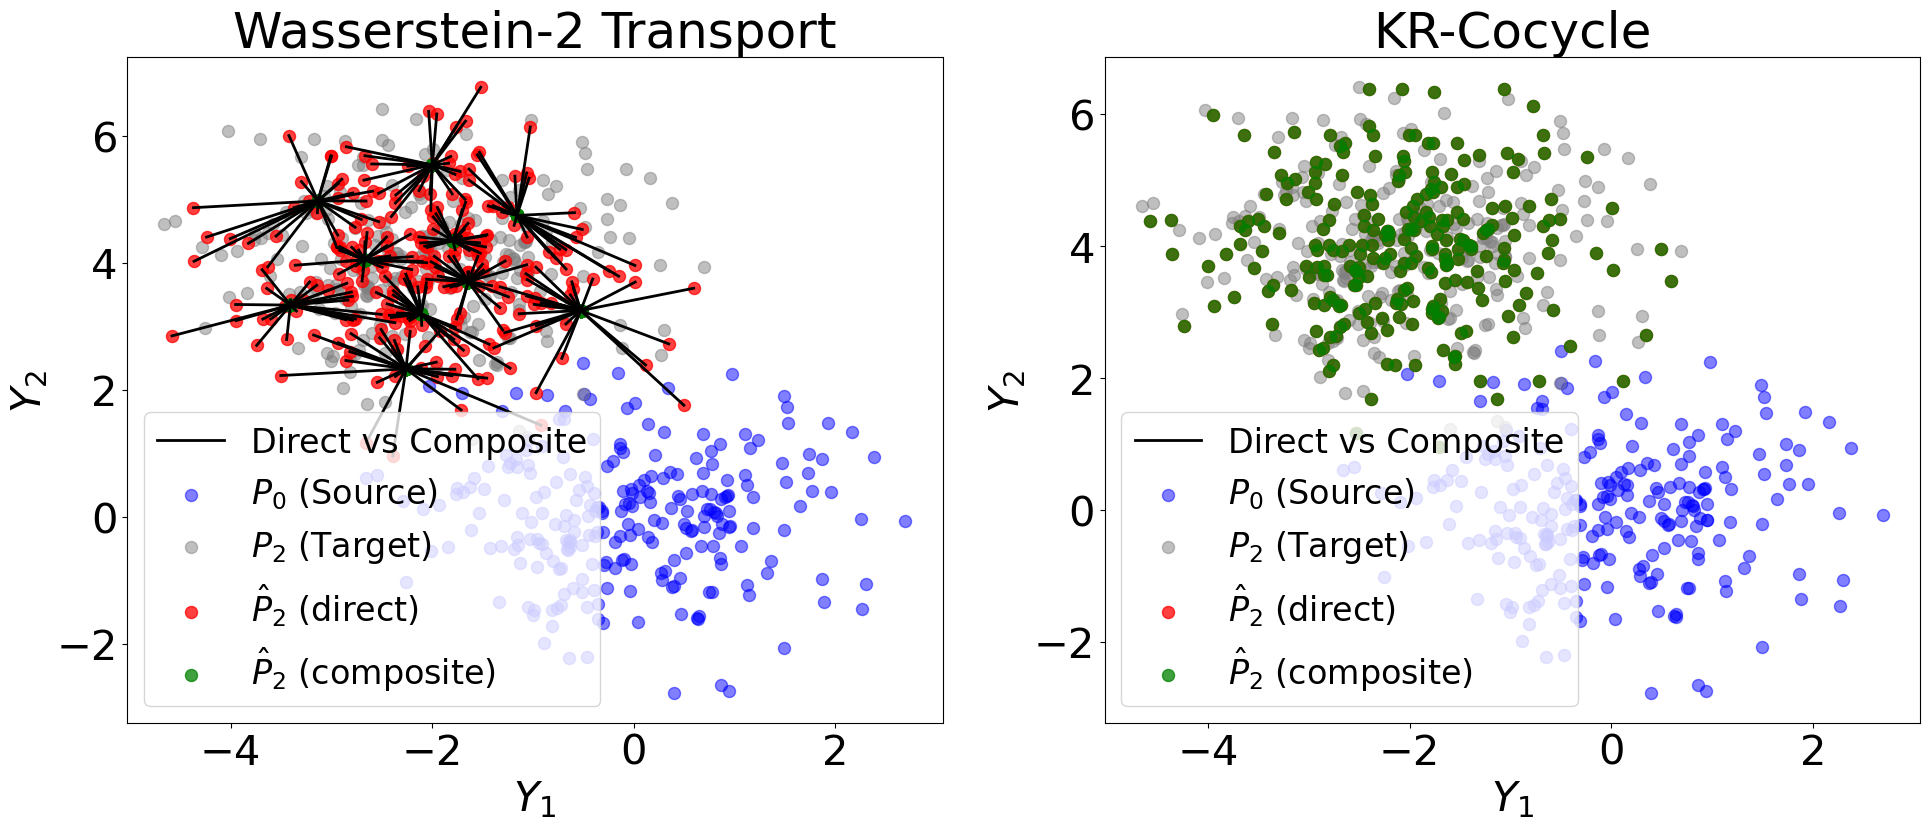

In [7]:
import matplotlib.pyplot as plt

# Increase font sizes roughly 4x larger than default
plt.rcParams.update({'font.size': 30})

# Define line widths and alpha for the two selected methods
lws = [2.0, 2.0]
alpha = [1.0, 1.0]
# Use colors corresponding to the second and fourth methods from your original color list.
colors = ["red", "red"]
colors_c = ["green", "green"]

# We'll only plot the 2nd and 4th methods.
selected_indices = [1, 4]

# Define method labels for the selected methods.
method_labels = ["Wasserstein-2 Transport", "KR-Cocycle"]

# Create a 1x2 subplot grid (increasing size since we now have 2 subplots)
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

for idx, ax in zip(selected_indices, axes):
    # Extract the direct and composite predicted Y2's for method idx
    Y2_direct = Y2preds_direct[idx]
    Y2_composite = Y2preds_composite[idx]

    # Draw dashed lines connecting each direct point to its composite counterpart
    for j in range(P0.shape[0]):
        if j == 0:
            ax.plot([Y2_direct[j, 0], Y2_composite[j, 0]],
                    [Y2_direct[j, 1], Y2_composite[j, 1]],
                    'k-', linewidth=lws[selected_indices.index(idx)], alpha=alpha[selected_indices.index(idx)],
                    label='Direct vs Composite')
        else:
            ax.plot([Y2_direct[j, 0], Y2_composite[j, 0]],
                    [Y2_direct[j, 1], Y2_composite[j, 1]],
                    'k-', linewidth=lws[selected_indices.index(idx)], alpha=alpha[selected_indices.index(idx)])
    
    # Scatter plot for the source (P0) and target (P2) distributions for context.
    # Here we assume that P0 represents the source outcomes, and we add the true shift to P0 to represent P2.
    ax.scatter(P0[:, 0], P0[:, 1], label='$P_0$ (Source)', color='blue', alpha=0.5, s = 75)
    ax.scatter(P0[:, 0] + true_shift_20[0], P0[:, 1] + true_shift_20[1], 
               label='$P_2$ (Target)', color='gray', alpha=0.5, s = 75)
    
    # Scatter plot for the direct mapping predictions (using a marker and the selected color)
    ax.scatter(Y2_direct[:, 0], Y2_direct[:, 1], marker='o', color=colors[selected_indices.index(idx)],
               label=r'$\hat P_2$ (direct)', alpha=0.75, s = 75)
    ax.scatter(Y2_composite[:, 0], Y2_composite[:, 1], marker='o', color=colors_c[selected_indices.index(idx)],
               label=r'$\hat P_2$ (composite)', alpha=0.75, s = 75)
    
    # Set axis labels and title for each subplot
    ax.set_xlabel("$Y_1$")
    ax.set_ylabel("$Y_2$")
    ax.set_title(method_labels[selected_indices.index(idx)])
    ax.legend(fontsize=24)

plt.tight_layout()
fig.savefig("2dtransportmaps_inconsistencies_selected.png", bbox_inches="tight")

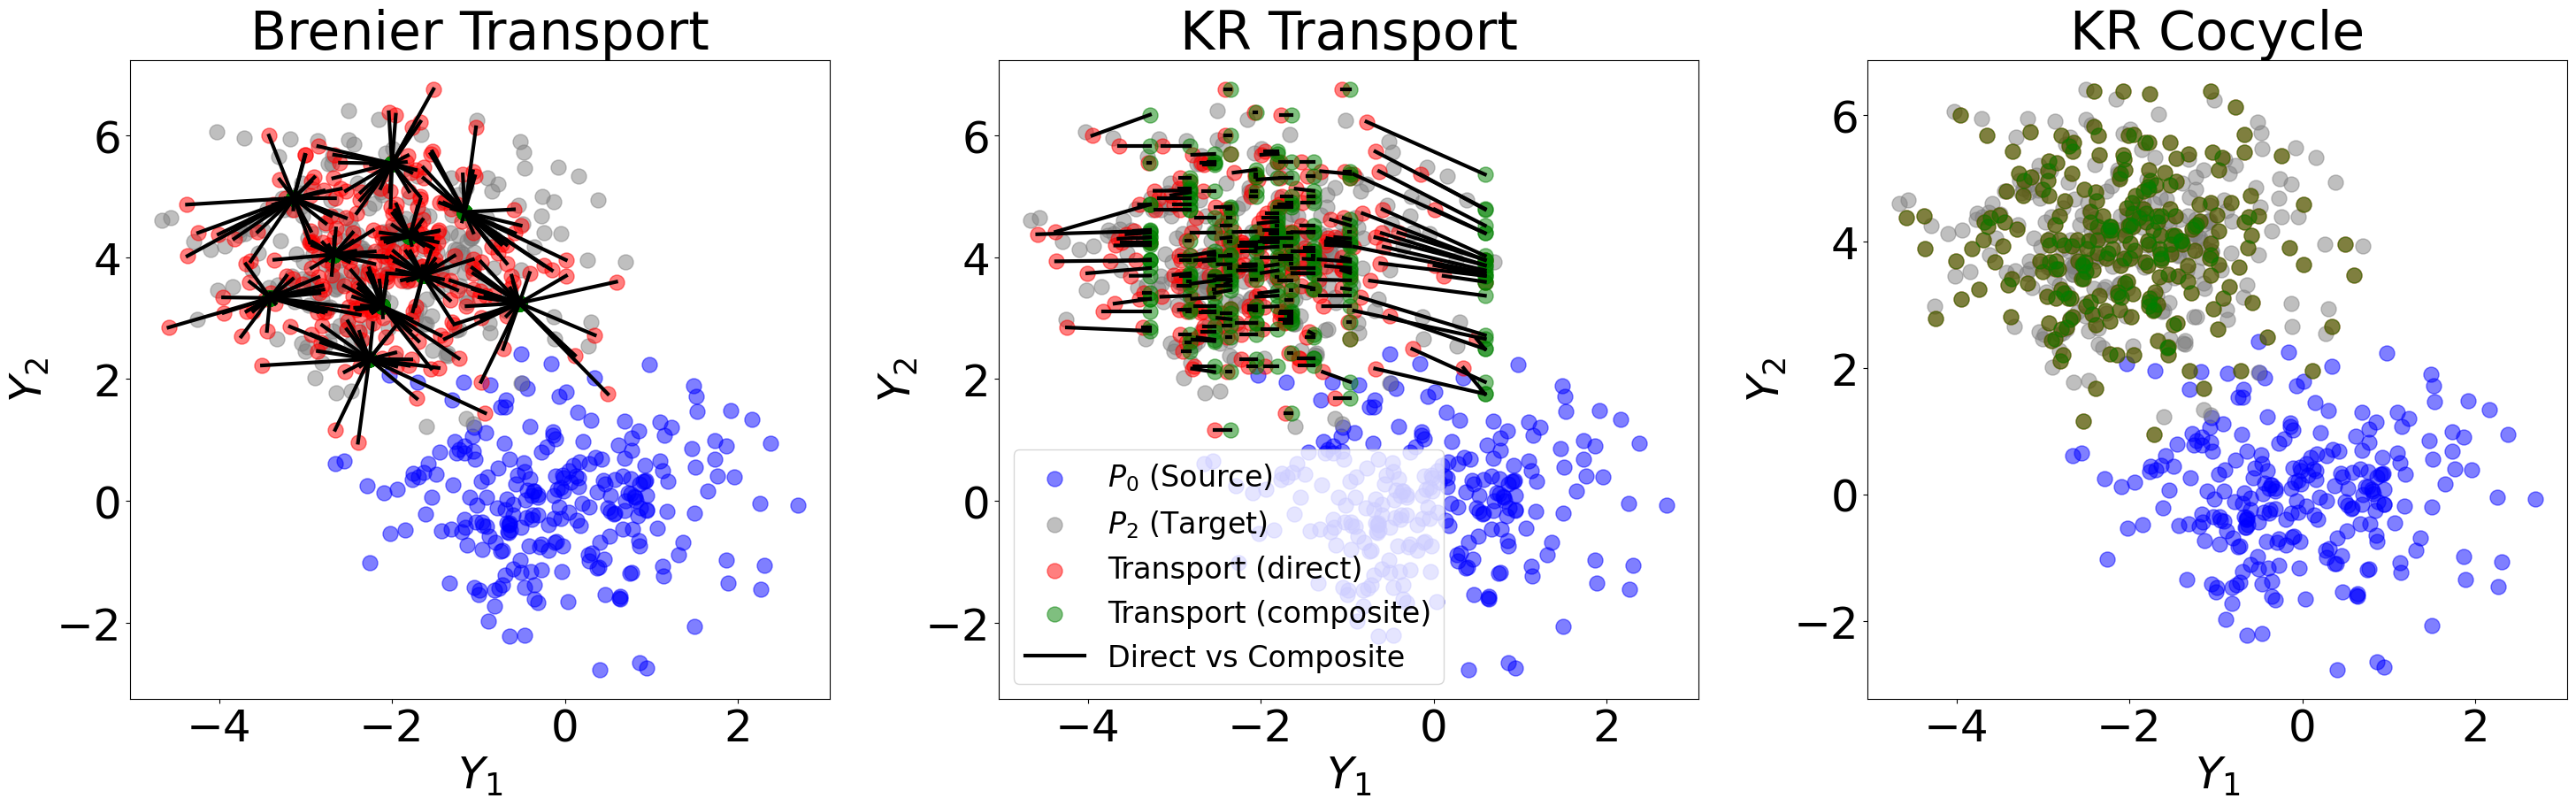

In [16]:
import matplotlib.pyplot as plt

# Increase font sizes roughly 4x larger than default
plt.rcParams.update({'font.size': 36})

# Define line widths and alpha for the selected methods
lws = [3.0, 3.0, 3.0]
alpha = [1.0, 1.0, 1.0]
# Define colors for the first, second, and last methods.
selected_colors = ["red", "red", "red"]
selected_colors_comp = ["green", "green", "green"]

# We'll plot the 1st, 2nd, and 4th methods (indices 0, 1, and 3)
selected_indices = [1, 3, 4]

# Define method labels for the selected methods.
# Original order: ["Wasserstein-1 Transport", "Wasserstein-2 Transport", r"Wasserstein-$\infty$ Transport", "KR-Cocycle"]
# For indices 0, 1, and 3 we get:
method_labels = ["Brenier Transport", "KR Transport", "KR Cocycle"]

# Create a 1x3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for idx, ax in zip(selected_indices, axes):
    # Extract the direct and composite predicted Y2's for method idx
    Y2_direct = Y2preds_direct[idx]
    Y2_composite = Y2preds_composite[idx]
    
    # Scatter plot for the source (P0) and target (P2) distributions for context.
    # Assume P0 is the source; adding the true shift yields the target P2.
    ax.scatter(P0[:, 0], P0[:, 1], label='$P_0$ (Source)', color='blue', alpha=0.5, s=150)
    ax.scatter(P0[:, 0] + true_shift_20[0], P0[:, 1] + true_shift_20[1], 
               label='$P_2$ (Target)', color='gray', alpha=0.5, s=150)
    
    # Scatter plot for the direct mapping predictions using the selected color.
    ax.scatter(Y2_direct[:, 0], Y2_direct[:, 1], marker='o', color=selected_colors[selected_indices.index(idx)],
               label=r'Transport (direct)', alpha=0.5, s=150)
    ax.scatter(Y2_composite[:, 0], Y2_composite[:, 1], marker='o', color=selected_colors_comp[selected_indices.index(idx)],
               label=r'Transport (composite)', alpha=0.5, s=150)
    # Draw dashed lines connecting each direct prediction to its composite counterpart.
    for j in range(P0.shape[0]):
        if j == 0:
            ax.plot([Y2_direct[j, 0], Y2_composite[j, 0]],
                    [Y2_direct[j, 1], Y2_composite[j, 1]],
                    'k-', linewidth=lws[selected_indices.index(idx)], alpha=alpha[selected_indices.index(idx)],
                    label='Direct vs Composite')
        else:
            ax.plot([Y2_direct[j, 0], Y2_composite[j, 0]],
                    [Y2_direct[j, 1], Y2_composite[j, 1]],
                    'k-', linewidth=lws[selected_indices.index(idx)], alpha=alpha[selected_indices.index(idx)])
    
    # Set axis labels and title for each subplot.
    ax.set_xlabel("$Y_1$")
    ax.set_ylabel("$Y_2$")
    ax.set_title(method_labels[selected_indices.index(idx)])
    # Optionally, add legend to the last subplot to avoid clutter.
    if idx == selected_indices[1]:
        ax.legend(fontsize=24)

plt.tight_layout()
fig.savefig("2dtransportmaps_inconsistencies_unbalanced.png", bbox_inches="tight")

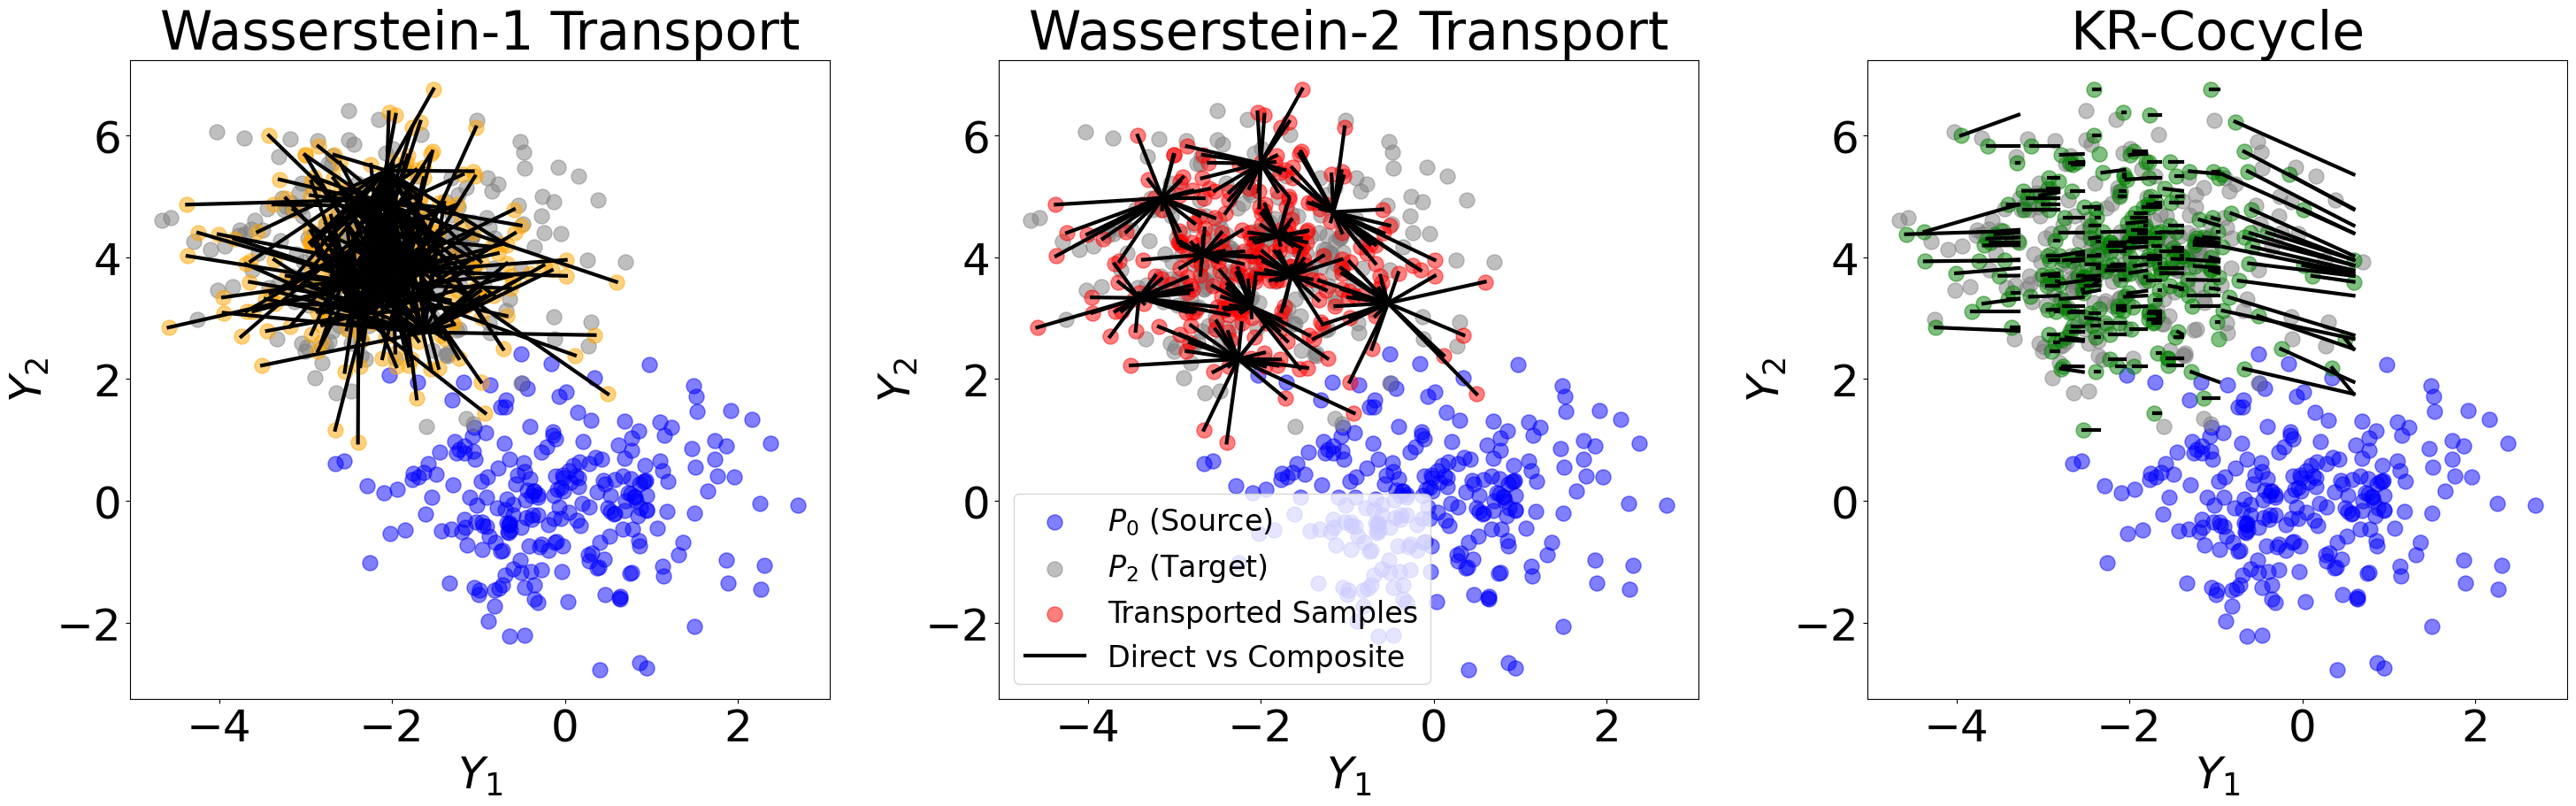

In [9]:
import matplotlib.pyplot as plt

# Increase font sizes roughly 4x larger than default
plt.rcParams.update({'font.size': 36})

# Define line widths and alpha for the selected methods
lws = [3.0, 3.0, 3.0]
alpha = [1.0, 1.0, 1.0]
# Define colors for the first, second, and last methods.
selected_colors = ["orange", "red", "green"]

# We'll plot the 1st, 2nd, and 4th methods (indices 0, 1, and 3)
selected_indices = [0, 1, 3]

# Define method labels for the selected methods.
# Original order: ["Wasserstein-1 Transport", "Wasserstein-2 Transport", r"Wasserstein-$\infty$ Transport", "KR-Cocycle"]
# For indices 0, 1, and 3 we get:
method_labels = ["Wasserstein-1 Transport", "Wasserstein-2 Transport", "KR-Cocycle"]

# Create a 1x3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

for idx, ax in zip(selected_indices, axes):
    # Extract the direct and composite predicted Y2's for method idx
    Y2_direct = Y2preds_direct[idx]
    Y2_composite = Y2preds_composite[idx]
    
    # Scatter plot for the source (P0) and target (P2) distributions for context.
    # Assume P0 is the source; adding the true shift yields the target P2.
    ax.scatter(P0[:, 0], P0[:, 1], label='$P_0$ (Source)', color='blue', alpha=0.5, s=150)
    ax.scatter(P0[:, 0] + true_shift_20[0], P0[:, 1] + true_shift_20[1], 
               label='$P_2$ (Target)', color='gray', alpha=0.5, s=150)
    
    # Scatter plot for the direct mapping predictions using the selected color.
    ax.scatter(Y2_direct[:, 0], Y2_direct[:, 1], marker='o', color=selected_colors[selected_indices.index(idx)],
               label='Transported Samples', alpha=0.5, s=150)
    
    # Draw dashed lines connecting each direct prediction to its composite counterpart.
    for j in range(P0.shape[0]):
        if j == 0:
            ax.plot([Y2_direct[j, 0], Y2_composite[j, 0]],
                    [Y2_direct[j, 1], Y2_composite[j, 1]],
                    'k-', linewidth=lws[selected_indices.index(idx)], alpha=alpha[selected_indices.index(idx)],
                    label='Direct vs Composite')
        else:
            ax.plot([Y2_direct[j, 0], Y2_composite[j, 0]],
                    [Y2_direct[j, 1], Y2_composite[j, 1]],
                    'k-', linewidth=lws[selected_indices.index(idx)], alpha=alpha[selected_indices.index(idx)])
    
    # Set axis labels and title for each subplot.
    ax.set_xlabel("$Y_1$")
    ax.set_ylabel("$Y_2$")
    ax.set_title(method_labels[selected_indices.index(idx)])
    # Optionally, add legend to the last subplot to avoid clutter.
    if idx == selected_indices[1]:
        ax.legend(fontsize=24)

plt.tight_layout()
fig.savefig("2dtransportmaps_inconsistencies_selected.png", bbox_inches="tight")

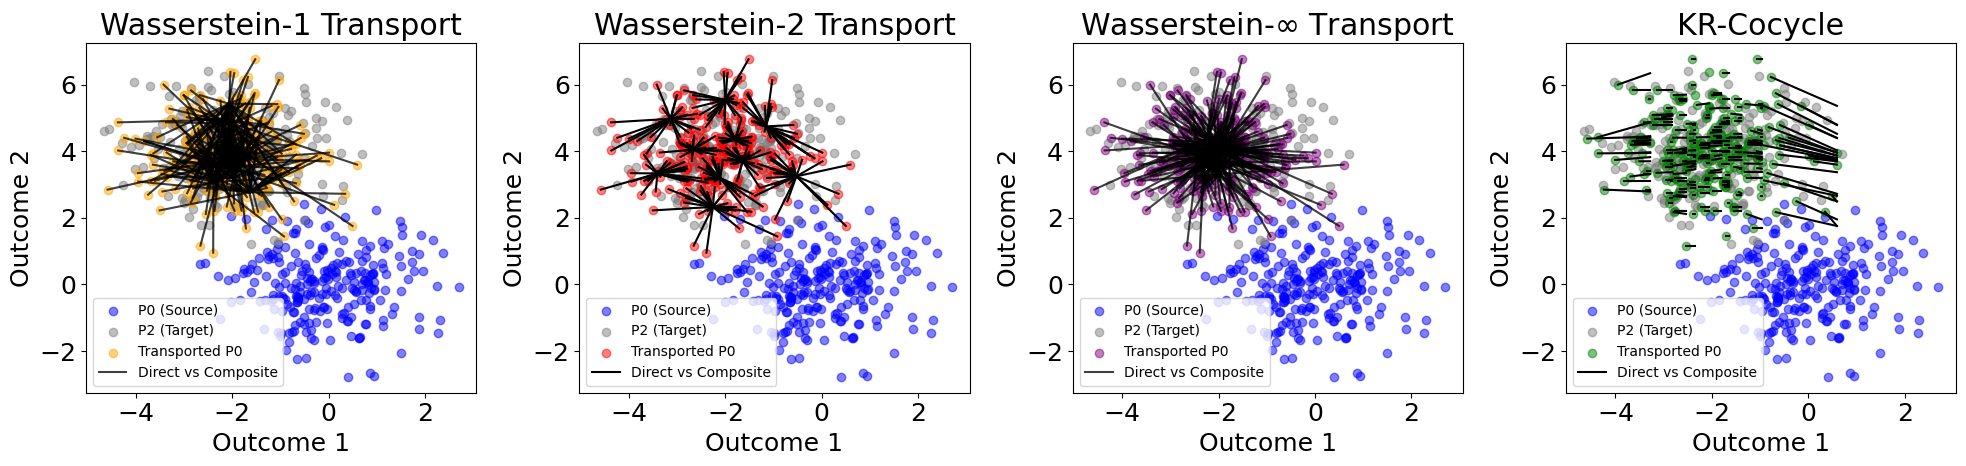

In [10]:
import matplotlib.pyplot as plt

# Increase font sizes roughly 4x larger than default
plt.rcParams.update({'font.size': 18})

lws = [1.5,1.5,1.5,1.5]
alpha = [0.75,1.0,0.75,1.0]
colors = ["orange", "red", "purple", "green"]

# Create a 1x4 subplot grid
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Labels for the methods (first three from the distances list, and then KRcocycle)
method_labels = ["Wasserstein-1 Transport","Wasserstein-2 Transport",r"Wasserstein-$\infty$ Transport", "KR-Cocycle"]

# For each method, plot the counterfactuals and draw connecting lines for the inconsistencies.
for i in range(4):
    # Extract the direct and composite predicted Y2's for method i
    Y2_direct = Y2preds_direct[i]
    Y2_composite = Y2preds_composite[i]
    
    # Scatter plot for the source (P0) and target (P2) distributions for context
    axes[i].scatter(P0[:, 0], P0[:, 1], label='P0 (Source)', color='blue', alpha=0.5)
    axes[i].scatter(P0[:, 0]+ true_shift_20[0], P0[:, 1]+ true_shift_20[1], label='P2 (Target)', color='gray', alpha=0.5)
    
    # Scatter plot for the direct mapping (red circles)
    axes[i].scatter(Y2_direct[:, 0], Y2_direct[:, 1], marker='o', color=colors[i], label='Transported P0', alpha = 0.5)
    # Scatter plot for the composite mapping (green crosses)
    #axes[i].scatter(Y2_composite[:, 0], Y2_composite[:, 1], marker='d', color='green', label='Composite Map', alpha = 0.5)
    
    # Draw dashed lines connecting each direct point to its composite counterpart
    for j in range(P0.shape[0]):
        if j == 0:
            axes[i].plot([Y2_direct[j, 0], Y2_composite[j, 0]],
                     [Y2_direct[j, 1], Y2_composite[j, 1]],
                     'k-', linewidth=lws[i], alpha = alpha[i], label = "Direct vs Composite")
        axes[i].plot([Y2_direct[j, 0], Y2_composite[j, 0]],
                     [Y2_direct[j, 1], Y2_composite[j, 1]],
                     'k-', linewidth=lws[i], alpha = alpha[i])
    
    # Set the title, labels and add a legend
    axes[i].set_title(method_labels[i])
    axes[i].set_xlabel("Outcome 1")
    axes[i].set_ylabel("Outcome 2")
    axes[i].legend(fontsize = 10)

plt.tight_layout()
fig.savefig("2dtransportmaps_inconsistencies.png", bbox_inches = "tight")

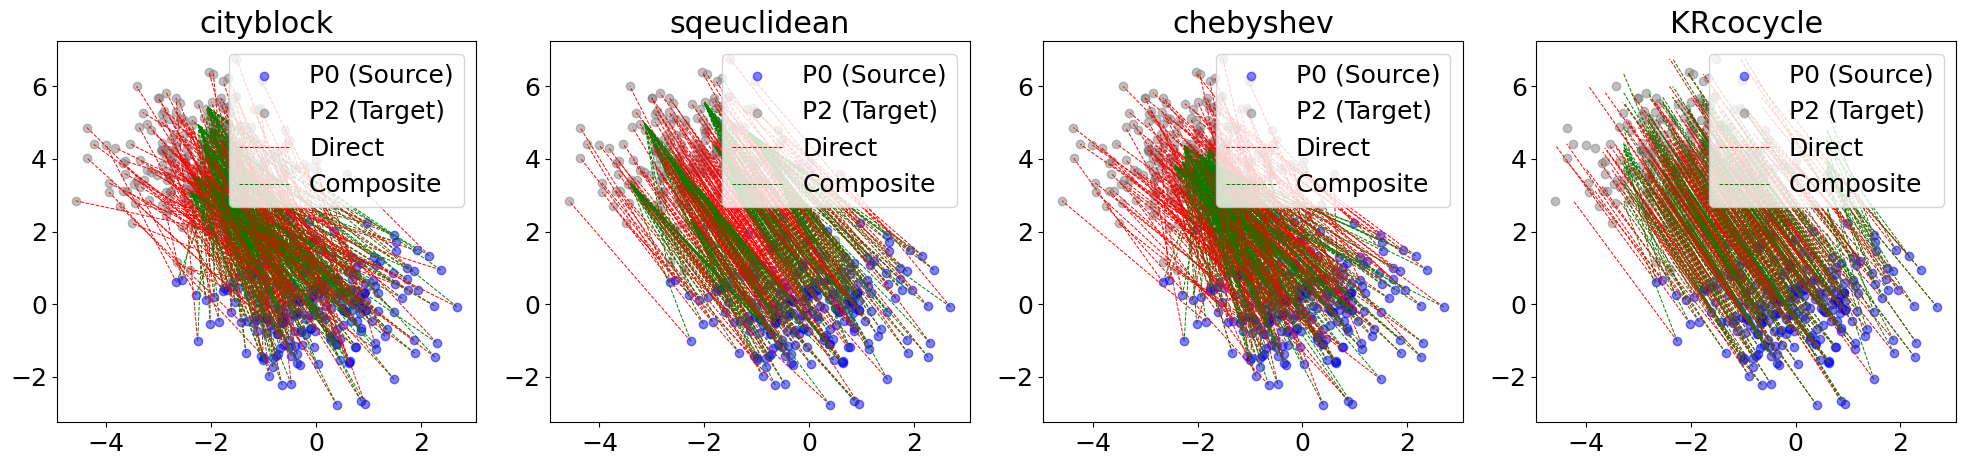

In [11]:
import matplotlib.pyplot as plt

# Create a 1x4 subplot grid
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Define method labels: first three correspond to the distances, fourth is KRcocycle.
method_labels = distances + ["KRcocycle"]

# For each method, plot the trajectories from P0 to the predicted Y2s.
for i in range(4):
    # Extract predictions for method i:
    Y2_direct = Y2preds_direct[i]
    Y2_composite = Y2preds_composite[i]
    
    # Plot the source points P0 for context.
    axes[i].scatter(P0[:, 0], P0[:, 1], label='P0 (Source)', color='blue', alpha=0.5)
    # Optionally, you can also plot the target points P2 for context.
    axes[i].scatter(P2[:, 0], P2[:, 1], label='P2 (Target)', color='gray', alpha=0.5)
    
    # For each source point, draw a trajectory line for the direct approach and one for the composite approach.
    for j in range(P0.shape[0]):
        # Draw a red dashed line from P0[j] to its direct prediction
        axes[i].plot([P0[j, 0], Y2_direct[j, 0]], [P0[j, 1], Y2_direct[j, 1]], 
                     'r--', linewidth=0.7, label='Direct' if j==0 else "")
        # Draw a green dashed line from P0[j] to its composite prediction
        axes[i].plot([P0[j, 0], Y2_composite[j, 0]], [P0[j, 1], Y2_composite[j, 1]], 
                     'g--', linewidth=0.7, label='Composite' if j==0 else "")
    
    axes[i].set_title(method_labels[i])
    axes[i].legend()

plt.tight_layout()
plt.show()

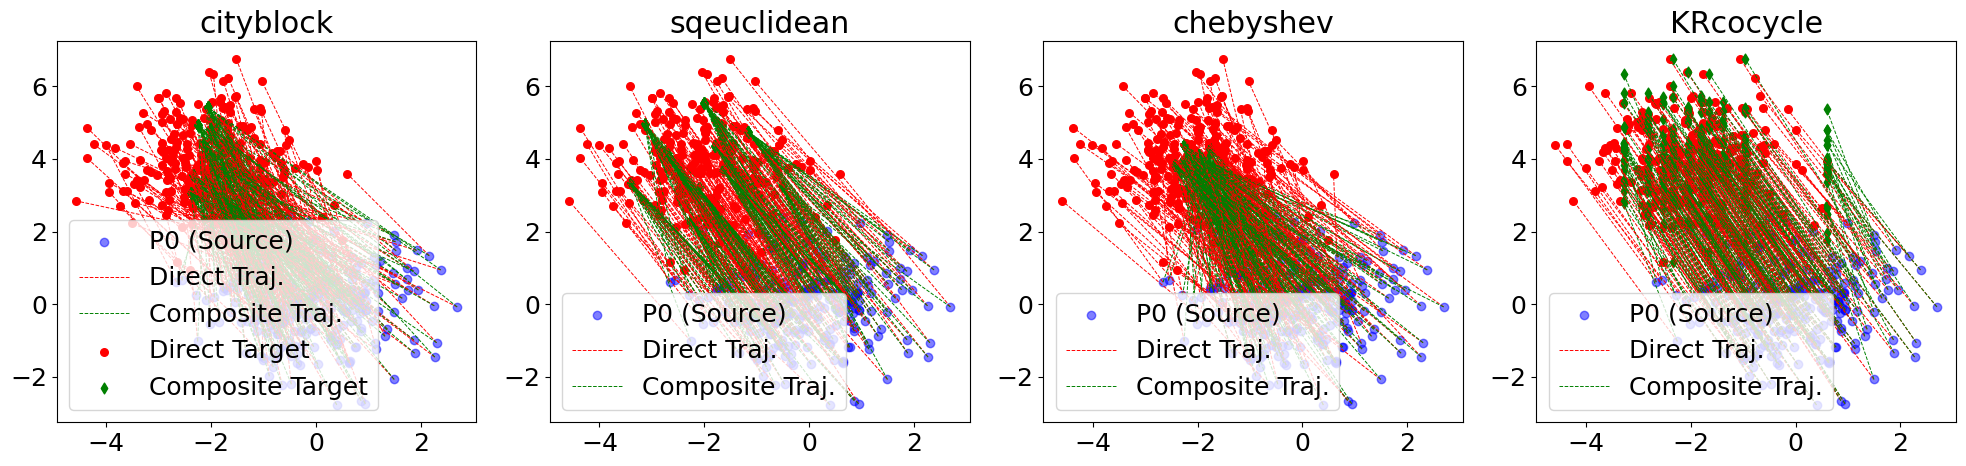

In [12]:
import matplotlib.pyplot as plt

# Create a 1x4 subplot grid
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Define method labels (first three from distances and the fourth from KRcocycle)
method_labels = distances + ["KRcocycle"]

for i in range(4):
    # Extract predictions for method i:
    Y2_direct = Y2preds_direct[i]
    Y2_composite = Y2preds_composite[i]
    
    # Plot the source points (P0) and true target points (P2) for context
    axes[i].scatter(P0[:, 0], P0[:, 1], label='P0 (Source)', color='blue', alpha=0.5)
   # axes[i].scatter(P2[:, 0], P2[:, 1], label='P2 (Target)', color='gray', alpha=0.5)
    
    # Draw trajectories for each source point:
    for j in range(P0.shape[0]):
        # Direct trajectory (red dashed)
        axes[i].plot([P0[j, 0], Y2_direct[j, 0]], [P0[j, 1], Y2_direct[j, 1]],
                     'r--', linewidth=0.7, label='Direct Traj.' if j == 0 else "")
        # Composite trajectory (green dashed)
        axes[i].plot([P0[j, 0], Y2_composite[j, 0]], [P0[j, 1], Y2_composite[j, 1]],
                     'g--', linewidth=0.7, label='Composite Traj.' if j == 0 else "")
    
    # Scatter the predicted target points:
    axes[i].scatter(Y2_direct[:, 0], Y2_direct[:, 1], marker='o', color='red',
                    s=30, label='Direct Target' if i==0 else "")
    axes[i].scatter(Y2_composite[:, 0], Y2_composite[:, 1], marker='d', color='green',
                    s=30, label='Composite Target' if i==0 else "")
    
    axes[i].set_title(method_labels[i])
    axes[i].legend()

plt.tight_layout()
plt.show()